# Quantum 2x2 Games

This notebook has been developed in order to formulate and analyze the quantum version of two canonical Game Theory problems: Prisoners' Dilemma and Battle of Sexes.

In [1]:
import numpy as np
import cmath
from scipy import linalg
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm

The action space of a quantum 2x2 game is SU(2), i.e. the Hilbert space of unitary, trace-preserving 2x2 matrices.

A generic matrix in SU(2) can be written as a function of 2 parameters: <br>

$$
\hat{U}(\theta,\phi) = \begin{pmatrix}
e^{i\phi}\cos\theta/2 & \sin\theta/2 \\ -\sin\theta/2 & e^{-i\phi}\cos\theta/2
\end{pmatrix} \quad \theta\in[0,\pi], \phi\in[0,\frac{\pi}{2}] 
$$

and so it is possible to write a function that construct a generic quantum strategy accessible by one of the players.

In [2]:
def quantum_strategy(theta, phi):
    
    qs = np.zeros([2,2], dtype=complex)
    qs[0,0] = cmath.exp(1j*phi)*np.cos(theta/2)
    qs[0,1] = np.sin(theta/2)
    qs[1,0] = -np.sin(theta/2)
    qs[1,1] = cmath.exp(-1j*phi)*np.cos(theta/2)
    
    return qs

Also the original pure strategies C and D can be written in this way:

$$
\hat{C} = \hat{U}(0,0) = \begin{pmatrix}1&0\\0&1\end{pmatrix} \qquad
\hat{D} = \hat{U}(\pi,0) = \begin{pmatrix}0&1\\-1&0\end{pmatrix}
$$

In [3]:
C = quantum_strategy(0, 0)
D = quantum_strategy(np.pi, 0)

Usually, in these kind of games, each player has access to two pure strategies, C for cooperating and D for defecting, and to the corresponding payoff bymatrix:

$$
\begin{pmatrix}
P_{CC,A},P_{CC,B} & P_{CD,A},P_{CD,B} \\ P_{DC,A},P_{DC,B} & P_{DD,A},P_{DD,B} \\
\end{pmatrix}
$$

The states of the (quantum) system are defined, as said, in SU(2), and are expressed as column vectors with four elements, written in the basis given by {|CC>, |CD>, |DC>, |DD>}, i.e. the computational basis (for example, |CC> corresponds to the vector (1,0,0,0), and so on).

In order to construct an effective quantum game, we need to provide also some kind of entanglement between the various states, and this will be possible introducing an operator that depends on a "entanglement measure"

$$
\hat{J} = \exp\left(-i\gamma\hat{D}\otimes\hat{D}/2\right) \qquad \gamma\in[0,\frac{\pi}{2}]
$$

such that the final state of the system, after the application of the actions chosen by the players, but before the effective measure of the qubits, will be given by:

$$
|\psi_f> = \hat{J}^\dagger\left(\hat{U}_A\otimes\hat{U}_B\right)\hat{J}|CC>
$$

In [4]:
def compute_final_state( strategyA, strategyB, gamma ):
    
    # Construct matrix J
    J = linalg.expm(-1j*gamma*np.kron(D,D)/2)
    # J^+ is just J's adjoint
    J1 = J.conjugate().transpose()
    # UA x UB is the kronecker product between the two quantum strategies
    UAB = np.kron(strategyA, strategyB)
    
    # Apply the operators one by one
    psi_f = np.matmul(J,np.array([1,0,0,0]))
    psi_f = np.matmul(UAB, psi_f)
    psi_f = np.matmul(J1, psi_f)
    
    return psi_f

In the end, since the only way to find the best set of strategies to follow is to check the payoff, the formula to compute the expected utility for player i is:

$$
<i> = P_{CC,i}\cdot|<CC|\psi_f>|^2 + P_{CD,i}\cdot|<CD|\psi_f>|^2 + P_{DC,i}\cdot|<DC|\psi_f>|^2 + P_{DD,i}\cdot|<DD|\psi_f>|^2
$$

In [5]:
def expected_payoffs( state, payoff_bymatrix ):
    
    payoffA, payoffB = 0, 0
    
    for i in range(2):
        for j in range(2):
            payoffA += payoff_bymatrix['A'][i,j]*(abs(state[2*i+j])**2)
            payoffB += payoff_bymatrix['B'][i,j]*(abs(state[2*i+j])**2)
    
    return [payoffA, payoffB]

Just to check the correctness of our code, we can rely on the fact that selecting $\gamma=0$ we should obtain the original classical game! <br>
So, if for example, we ask the two players to choose the joint strategy {DC}, then as final state we should get |DC> in the computational basis, that is (0,0,1,0).

In [6]:
compute_final_state( strategyA=D, strategyB=C, gamma=0 ).astype(int)

/home/mattia/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: ComplexWarning: Casting complex values to real discards the imaginary part
  """Entry point for launching an IPython kernel.


array([ 0,  0, -1,  0])

Note: the -  sign in the coefficient is irrelevant because what matters is its square module, i.e. $|-1|^2$, that represents the probability of finding the system in the state CD.

So everything seems working fine!

# Quantum Prisoners' Dilemma

The first problem that we are going to simulate as a quantum system is the traditional Prisoners' Dilemma.

In [7]:
# Specify the payoff matrix
payoff_matrix_pd = {'A' : np.array([[3,0],[5,1]]), 'B' : np.array([[3,5],[0,1]]) }

In [8]:
fs = compute_final_state( strategyA=D, strategyB=C, gamma=0 )

In [9]:
print(fs)
expected_payoffs( fs, payoff_matrix_pd )

[ 6.123234e-17+0.j  0.000000e+00+0.j -1.000000e+00+0.j  0.000000e+00+0.j]


[5.0, 1.1248198369963932e-32]

It may be interesting, now, to analyze the different payoffs of player A in particular configurations. Then the game, at least for the moment is symmetric, and so we are allowed to draw the same conclusions also for player B.

Let's set $\gamma=0$ and construct a discrete 4-dimensional grid for all the possible values of the parameters $\theta$ and $\phi$ for both players.

In [17]:
# Fix some default value for the parameters 
grid_step = 0.2

thetaA = np.arange(0, np.pi, grid_step)
phiA   = np.arange(0, np.pi/2, grid_step)
thetaB = np.arange(0, np.pi, grid_step)
phiB   = np.arange(0, np.pi/2, grid_step)

In [32]:
# Define a function that construct a grid of values considering all the possible 
#combinations of the 4 parameters given in input

def payoff_grid(thetaA, phiA, thetaB, phiB, payoff_matrix, gamma, verbose):
    
    size = len(thetaA)*len(phiA)*len(thetaB)*len(phiB)
    grid = np.zeros(shape=(size,6))
    if(verbose): pbar = tqdm(total = size)
    s = 0

    for i in thetaA:
        for j in phiA:
            for k in thetaB:
                for l in phiB:
                    sA = quantum_strategy(i, j)
                    sB = quantum_strategy(k, l)
                    fs = compute_final_state(sA, sB, gamma)  
                    utility = expected_payoffs(fs, payoff_matrix)
                    grid[s] = [i, j, k, l, utility[0], utility[1]]
                    s += 1
                    if(verbose): pbar.update(1)
    
    # Construct a pandas DataFrame with the grid
    df = pd.DataFrame(grid, columns=["thetaA","phiA","thetaB","phiB","utilityA", "utilityB"])
    
    return df
                

First, let's study the case with $\gamma=0$. <br>
In order to find the best responses of player A to each of the strategies of B, we run a loop

In [27]:
test_thetaA = np.linspace(0, np.pi, 50)
test_phiA = np.linspace(0, np.pi/2, 50)
min_utils = np.zeros(shape=(len(test_thetaA)*len(test_phiA), 3))
s = 0

for tA in test_thetaA:
    for pA in test_phiA:
        
        # Take the minimum payoff achievable if A plays U(tA, pA)
        min_uA = payoff_grid([tA], [pA], thetaB, phiB, payoff_matrix_pd, 0, False).max()["utilityA"]
        min_utils[s] = [tA, pA, min_uA]
        s+=1

100%|██████████| 128/128 [00:00<00:00, 3305.39it/s]


100%|██████████| 128/128 [00:00<00:00, 2692.04it/s]


100%|██████████| 128/128 [00:00<00:00, 3348.29it/s]


100%|██████████| 128/128 [00:00<00:00, 2803.85it/s]


100%|██████████| 128/128 [00:00<00:00, 2874.18it/s]


100%|██████████| 128/128 [00:00<00:00, 3367.99it/s]


100%|██████████| 128/128 [00:00<00:00, 2638.63it/s]


100%|██████████| 128/128 [00:00<00:00, 2945.97it/s]


100%|██████████| 128/128 [00:00<00:00, 3602.65it/s]


100%|██████████| 128/128 [00:00<00:00, 3345.74it/s]


100%|██████████| 128/128 [00:00<00:00, 3396.65it/s]


100%|██████████| 128/128 [00:00<00:00, 2850.44it/s]


100%|██████████| 128/128 [00:00<00:00, 3401.79it/s]


100%|██████████| 128/128 [00:00<00:00, 2951.61it/s]


100%|██████████| 128/128 [00:00<00:00, 3252.03it/s]


100%|██████████| 128/128 [00:00<00:00, 3457.04it/s]


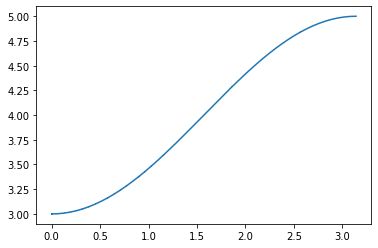

In [43]:
min_utils_df = pd.DataFrame(min_utils, columns=["thetaA", "phiA", "utilityA"])
plt.plot(min_utils_df["thetaA"], min_utils_df["utilityA"])

In [33]:
# The first case to study is the one with gamma=0
df_gamma0 = payoff_grid(thetaA, phiA, thetaB, phiB, payoff_matrix_pd, 0, verbose=False)

KeyboardInterrupt: 

In [20]:
df = pd.DataFrame(grid, columns=["thetaA","phiA","thetaB","phiB","utilityA"])

NameError: name 'grid' is not defined

In [25]:

payoff_grid([np.pi], [0], thetaB, phiB, payoff_matrix_pd, 0).max()["utilityA"]

100%|██████████| 128/128 [00:00<00:00, 2241.95it/s]


5.0

In [19]:
max_util = max(df["utilityA"])
df[df["utilityA"]==max_util]

NameError: name 'df' is not defined

Specification: because of the limited precision, some values in the table do not exactly correspond to the analytical results, but however they are still easily understandable (for example the maximum value of the utility, 4.999135 correspond to the utility of 5 in the payoff matrix). 

The highest utility value found for the first player is 5, and corresponds to the configuration in which:

* player A goes $\hat{U}(\theta=\pi, \phi)$
* player B goes $\hat{U}(\theta=0, \phi=0)$ or $\hat{U}(\theta=0, \phi=\pi/2)$

Since data are 5-dimensional, it can be very difficult to represent them. For this reason in the cells that follow several representation methods, from different point of views, will be used.

In [ ]:
# As a 3D surface
%matplotlib inline

fig = plt.figure(figsize=(16, 6))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

ax1.set_title(r'Payoff of player A as function of $\hat{U}_A$', fontsize=20)
ax1.set_xlabel(r'$\theta_A$', fontsize=20)
ax1.set_ylabel(r'$\phi_A$', fontsize=20)
ax1.set_zlabel(r'Payoff', fontsize=20)
ax1.set_xlim(0,np.pi)
ax1.set_ylim(0,np.pi/2)
ax1.set_zlim(2,5.5)
ax1.plot_trisurf(df["thetaA"],df["phiA"], df["utilityA"], 
                 cmap=plt.get_cmap("viridis"), linewidth = 0.2, antialiased = True, edgecolor="grey")
ax1.view_init(elev=30, azim=250)

ax2.set_title(r'Payoff of player A as function of $\hat{U}_B$', fontsize=20)
ax2.set_xlabel(r'$\theta_B$', fontsize=20)
ax2.set_ylabel(r'$\phi_B$', fontsize=20)
ax2.set_zlabel(r'Payoff', fontsize=20)
ax2.set_xlim(0,np.pi)
ax2.set_ylim(0,np.pi/2)
ax2.set_zlim(0,3.5)
ax2.plot_trisurf(df["thetaB"],df["phiB"], df["utilityA"], 
                 cmap=plt.get_cmap("viridis"), linewidth = 0.2, antialiased = True, edgecolor="grey");

Notice that the parameters $\phi_A$ and $\phi_B$ seems to be ininfluent on the final payoff: the reason is that since $\gamma=0$, all the probabilities and the states of the two players are separable, and so all these complex phases vanishes when multiplying first by $\hat{J}$ and then by $\hat{J^\dagger}$. <br>
So the next plot that is reasonable to study under this configuration is the utility as function of the parameters $\theta$. And this time an heatmap could be more clear than a 3D surface.

In [ ]:
plt.imshow(np.outer(thetaA, thetaB))

### Quantum player vs Classical opponent

What happen, instead, if we force player B to use only classic strategies while A can still exploit the quantum ones? <br>
This means restricting strategies of B to the set $\hat{U}(\theta,0)$.

In [ ]:
# Take from the grid only the lines with phiB = 0
df_qvsc = df.loc[df["phiB"]==0, ["thetaA", "phiA", "thetaB", "utilityA"]]

plt.plot(df["thetaA"], df["utilityA"])

In [ ]:
%matplotlib inline

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(df["thetaA"],df["phiA"], df["utilityA"],c=df["utilityA"])

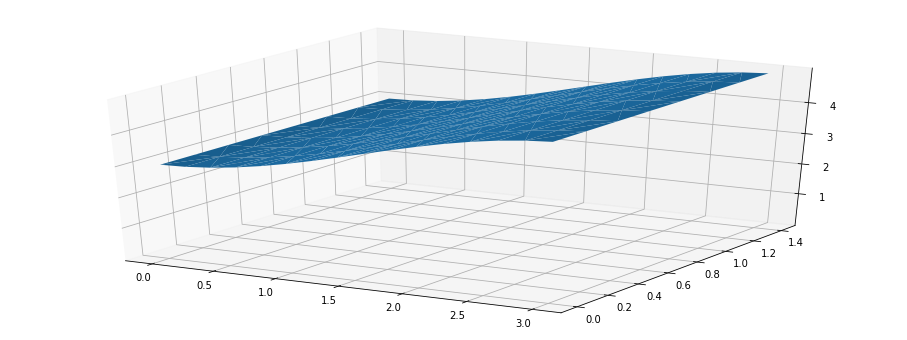

In [30]:
fig = plt.figure(figsize =(16, 9))   
ax = plt.axes(projection ='3d')   
fig = plt.figure(figsize=(16, 6))
ax3 = fig.add_subplot(111, projection='3d')
ax3.plot_trisurf(df["thetaA"],df["phiA"], df["utilityA"])